# Projet Data Mining

Max length = 2753
Max time = 2751 days 23:00:00


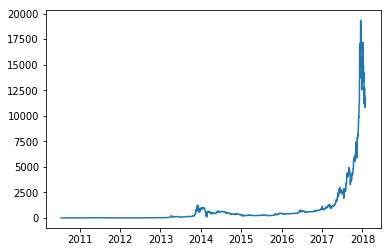

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np 
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

def daily_price_historical(symbol, comparison_symbol, histoday=True, limit=1, aggregate=1, allData='true'):
    # api url
    if histoday:
        url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}&allData={}' \
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)
    else:
        url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}&allData={}' \
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)

    # fetch data
    page = requests.get(url)
    data = page.json()['Data']

    # Convert Json to Table
    df = pd.DataFrame(data)

    # add a column with timestamp
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]

    return df


df = daily_price_historical('BTC', 'USD', True)
print('Max length = {}'.format(len(df)))
print('Max time = {}'.format((df.timestamp.max() - df.timestamp.min())))

plt.plot(df.timestamp, df.close)
plt.show()
df.head(5)
df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d')

In [2]:
df2 = df.set_index('timestamp')
df2

,close,high,low,open,time,volumefrom,volumeto
timestamp,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,1279324800,20.00,9.902000e-01
2010-07-18,0.08584,0.08585,0.05941,0.04951,1279411200,75.01,5.090000e+00
2010-07-19,0.08080,0.09307,0.07723,0.08584,1279497600,574.00,4.966000e+01
2010-07-20,0.07474,0.08181,0.07426,0.08080,1279584000,262.00,2.059000e+01
2010-07-21,0.07921,0.07921,0.06634,0.07474,1279670400,575.00,4.226000e+01
2010-07-22,0.05050,0.08181,0.05050,0.07921,1279756800,2160.00,1.297800e+02
2010-07-23,0.06262,0.06767,0.05050,0.05050,1279843200,2402.50,1.410700e+02
2010-07-24,0.05454,0.06161,0.05049,0.06262,1279929600,496.32,2.673000e+01
2010-07-25,0.05050,0.05941,0.05050,0.05454,1280016000,1551.48,8.506000e+01


In [3]:
pa = pd.read_csv('results.csv', usecols=["Date","Value"])
pa['Date'] = [pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in pa.Date]
pa = pa.set_index('Date')

18


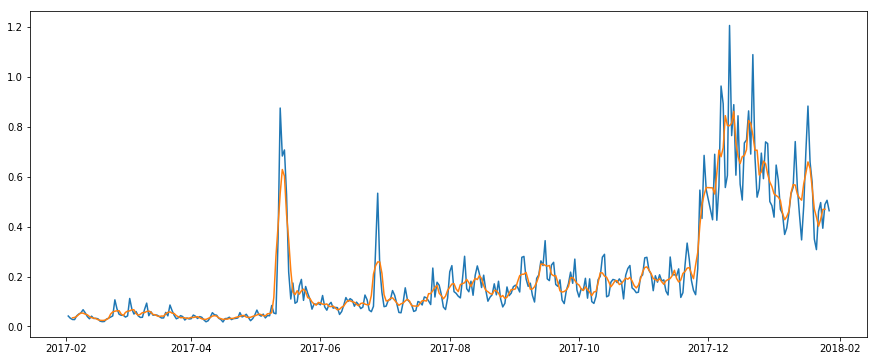

In [4]:
rcParams['figure.figsize'] = 15, 6
pa['mean'] = pa.rolling(window=5, center=True).mean()
ts = pa['mean']

print(np.count_nonzero(abs(ts-pa['Value'])>0.15))

plt.plot(pa)

### Création colonne buzz

In [5]:
pa['buzz']='c'
pa['buzz'][(pa['Value']-ts)>0.15]='u'
pa['buzz'][(pa['Value']-ts)<-0.15]='d'

### Concaténation avec la première table

In [6]:
pa = pa.join(df2)

In [7]:
pa = pa[['open','close','buzz']]

In [8]:
pa[pa['buzz']!='c']

,open,close,buzz
Date,,,
2017-05-11,1752.31,1819.29,d
2017-05-13,1686.39,1763.74,u
2017-06-28,2583.75,2577.74,u
2017-11-29,9906.04,9837.86,u
2017-12-04,11244.20,11623.91,u
2017-12-05,11624.37,11667.13,d
2017-12-07,13750.09,16850.31,u
2017-12-08,16867.98,16047.61,u
2017-12-09,16048.18,14843.42,d


In [9]:
pa['ecart'] = pa['close']-pa['open']

In [10]:
epsilon1 = 0.005
epsilon2 = 0.1
pa['variation'] = 0
pa['variation'][(pa['ecart']>pa['open']*epsilon1) & (pa['ecart']<pa['open']*epsilon2)] = 1
pa['variation'][(pa['ecart']<-pa['open']*epsilon1) & (pa['ecart']>-pa['open']*epsilon2)] = -1
pa['variation'][pa['ecart'] < -pa['open']*epsilon2] = -2
pa['variation'][pa['ecart'] > pa['open']*epsilon2] = 2
pa[abs(pa['variation'])>1]

,open,close,buzz,ecart,variation
Date,,,,,
2017-06-12,2973.45,2656.77,c,-316.68,-2
2017-07-15,2234.17,1975.08,c,-259.09,-2
2017-07-17,1914.09,2233.39,c,319.30,2
2017-07-20,2282.58,2866.02,c,583.44,2
2017-08-05,2878.49,3262.80,c,384.31,2
2017-09-14,3870.29,3243.08,c,-627.21,-2
2017-09-15,3243.08,3713.76,c,470.68,2
2017-09-18,3689.61,4100.28,c,410.67,2
2017-10-12,4824.20,5432.62,c,608.42,2


### Création de la variable d'ecart

In [11]:
print(sum(pa['variation']==-2))
print(sum(pa['variation']==-1))
print(sum(pa['variation']==0))
print(sum(pa['variation']==1))
print(sum(pa['variation']==2))

7
112
51
173
15


### Fonction de création des séquences

In [32]:
def sequences(taille, tab) :
    seq = [tab[i:(i+taille)] for i in range(len(tab[:-(taille-1)]))]
    return seq

In [40]:
def sequ_buzz(taille):
    tab = [[pa['variation'].loc[idx],pa['buzz'].loc[idx]] for idx in pa.index]
    return sequences(taille,tab)

In [41]:
sequ_buzz(4)

[[[1, 'c'], [1, 'c'], [1, 'c'], [-1, 'c']],
 [[1, 'c'], [1, 'c'], [-1, 'c'], [1, 'c']],
 [[1, 'c'], [-1, 'c'], [1, 'c'], [1, 'c']],
 [[-1, 'c'], [1, 'c'], [1, 'c'], [1, 'c']],
 [[1, 'c'], [1, 'c'], [1, 'c'], [-1, 'c']],
 [[1, 'c'], [1, 'c'], [-1, 'c'], [1, 'c']],
 [[1, 'c'], [-1, 'c'], [1, 'c'], [1, 'c']],
 [[-1, 'c'], [1, 'c'], [1, 'c'], [-1, 'c']],
 [[1, 'c'], [1, 'c'], [-1, 'c'], [0, 'c']],
 [[1, 'c'], [-1, 'c'], [0, 'c'], [1, 'c']],
 [[-1, 'c'], [0, 'c'], [1, 'c'], [0, 'c']],
 [[0, 'c'], [1, 'c'], [0, 'c'], [1, 'c']],
 [[1, 'c'], [0, 'c'], [1, 'c'], [1, 'c']],
 [[0, 'c'], [1, 'c'], [1, 'c'], [0, 'c']],
 [[1, 'c'], [1, 'c'], [0, 'c'], [0, 'c']],
 [[1, 'c'], [0, 'c'], [0, 'c'], [1, 'c']],
 [[0, 'c'], [0, 'c'], [1, 'c'], [1, 'c']],
 [[0, 'c'], [1, 'c'], [1, 'c'], [0, 'c']],
 [[1, 'c'], [1, 'c'], [0, 'c'], [1, 'c']],
 [[1, 'c'], [0, 'c'], [1, 'c'], [0, 'c']],
 [[0, 'c'], [1, 'c'], [0, 'c'], [-1, 'c']],
 [[1, 'c'], [0, 'c'], [-1, 'c'], [1, 'c']],
 [[0, 'c'], [-1, 'c'], [1, 'c'], [1, 'c'

### Recherche des séquences qui se répètent de taille max

In [ ]:
from collections import Counter
seqtest = sequences(3,ecart)
occmax = 1
tailleseq = 31
while occmax < 2 :
    seqtest = sequences(tailleseq,ecart)
    c = Counter(map(tuple,seqtest))
    c = pd.DataFrame.from_dict(c,orient='index').reset_index()
    c = c.rename(columns = {"index":"sequences",0:"occurences"} )
    c = c.sort_values(by="occurences",ascending=False)
    c = c.reset_index(drop = True)
    c= np.array(c)
    occmax = max(occmax,c[0,1])
    print(occmax)
    tailleseq -= 1
    
print(tailleseq+1)
print(c)
#c[sum(abs(c))>1]